In [97]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from algorithms import DecisionTree, RandomForest, KNN
from metrics import confusion_matrix,accuracy,specificity,precision,recall,f_score
#from sklearn.metrics import accuracy_score
#from metrics import confusion_matrix
import time
import joblib
from sklearn.metrics import classification_report

In [2]:
import math

def discretisation_width(dataset,columns,k=None):
    n = dataset.shape[0]
    if k==None:
        k = round(1 + (10 / 3) * math.log10(n))  
    for colonne in columns:
        val_column=dataset[colonne]
        largeur = (float(max(val_column)) - float(min(val_column))) / k  

        intervales = []
        for i in range(k):
            valI_min = round((min(val_column) + largeur * i), 4)
            valI_max = round((min(val_column) + largeur * (i + 1)), 4)
            limites = (valI_min, valI_max)
            intervales.append((i, limites))

        for index,valeur in enumerate(val_column):
            for i, limites in intervales:
                valMin, valMax = limites
                if valeur==max(val_column):
                    dataset.at[index, colonne] = k-1
                if valMin <= valeur < valMax:
                    dataset.at[index, colonne] = i
                    break
                
        dataset[colonne] = dataset[colonne].astype('category')
    return intervales


In [3]:
data = pd.read_csv("./new_dataset.csv")
data

,Fertility,N,P,K,pH,EC,S,Zn,Fe,Cu,Mn,B,OM
0,0,0.2389,0.3065,0.5008,0.3731,0.5600,0.3413,0.2459,0.0097,0.3487,0.4392,0.0568,0.5128
1,2,0.8599,0.6452,0.2828,0.9701,0.3733,0.5437,0.6885,0.3008,0.5077,0.4648,0.2955,0.9145
2,0,0.5796,0.2796,0.5008,0.2612,0.5733,0.7937,0.3279,0.0213,0.2462,0.3892,0.7727,0.5812
3,0,0.5796,0.2903,0.5008,0.4627,0.7200,0.5238,0.3770,0.0725,0.7590,0.1307,0.6023,0.6239
4,0,0.3790,0.4194,0.7346,0.3881,0.4933,1.0000,0.8197,0.0687,0.5436,0.3361,0.6705,0.8632
...,...,...,...,...,...,...,...,...,...,...,...,...,...
617,1,0.9172,0.4194,0.6003,0.7463,0.4133,0.4476,0.4426,0.4333,0.3077,0.5577,0.7159,0.1624
618,1,0.6401,0.3280,0.3839,0.2090,0.3600,0.1841,0.4262,0.7785,0.1846,0.4019,0.3864,0.0000
619,1,0.6783,0.3387,0.2006,0.4925,0.5600,0.4000,0.5410,0.3250,0.2769,0.3253,0.2955,0.3333
620,2,0.8185,0.5860,0.2338,0.3134,0.6000,0.3040,0.8033,0.4226,0.4769,0.6711,0.5341,0.8291


In [4]:
data_discretise=data.copy()
columns=data_discretise.columns[1:].tolist()
intervales=discretisation_width(data_discretise, columns, 3)

data_discretise

,Fertility,N,P,K,pH,EC,S,Zn,Fe,Cu,Mn,B,OM
0,0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0
1,2,2.0,1.0,0.0,2.0,1.0,1.0,2.0,0.0,1.0,1.0,0.0,2.0
2,0,1.0,0.0,1.0,0.0,1.0,2.0,0.0,0.0,0.0,1.0,2.0,1.0
3,0,1.0,0.0,1.0,1.0,2.0,1.0,1.0,0.0,2.0,0.0,1.0,1.0
4,0,1.0,1.0,2.0,1.0,1.0,1.0,2.0,0.0,1.0,1.0,2.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
617,1,2.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,0.0,1.0,2.0,0.0
618,1,1.0,0.0,1.0,0.0,1.0,0.0,1.0,2.0,0.0,1.0,1.0,0.0
619,1,2.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
620,2,2.0,1.0,0.0,0.0,1.0,0.0,2.0,1.0,1.0,2.0,1.0,2.0


In [332]:
data_discretise.to_csv("./new_dataset_discretise.csv",index=False)

In [4]:
data_discretise = pd.read_csv("./new_dataset_discretise.csv")

Séparation des données

For Decision Tree and Random Forest

In [5]:
# List of unique class labels
unique_classes = data_discretise['Fertility'].unique()

# Dictionary to store train and test sets for each class
class_splits = {}

# Loop through each class
for class_label in unique_classes:
    # Extract rows corresponding to the current class
    class_data_discretise = data_discretise[data_discretise['Fertility'] == class_label]

    # Split the class data_discretise into train and test sets
    X, y = class_data_discretise.iloc[:, 1:].values, class_data_discretise.iloc[:, 0].values
    X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(X, y, test_size=0.2, random_state=42)

    # Store the splits in the dictionary
    class_splits[class_label] = {'X_train': X_train_class, 'X_test': X_test_class, 'y_train': y_train_class, 'y_test': y_test_class}
# Concatenate the train and test sets 
X_train_1 = np.concatenate([class_splits[label]['X_train'] for label in unique_classes], axis=0)
X_test_1 = np.concatenate([class_splits[label]['X_test'] for label in unique_classes], axis=0)
y_train_1 = np.concatenate([class_splits[label]['y_train'] for label in unique_classes], axis=0)
y_test_1 = np.concatenate([class_splits[label]['y_test'] for label in unique_classes], axis=0)


For KNN

In [6]:
# List of unique class labels
unique_classes = data['Fertility'].unique()

# Dictionary to store train and test sets for each class
class_splits = {}

# Loop through each class
for class_label in unique_classes:
    # Extract rows corresponding to the current class
    class_data = data[data['Fertility'] == class_label]

    # Split the class data into train and test sets
    X, y = class_data.iloc[:, 1:].values, class_data.iloc[:, 0].values
    X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(X, y, test_size=0.2, random_state=42)

    # Store the splits in the dictionary
    class_splits[class_label] = {'X_train': X_train_class, 'X_test': X_test_class, 'y_train': y_train_class, 'y_test': y_test_class}
# Concatenate the train and test sets 
X_train_2 = np.concatenate([class_splits[label]['X_train'] for label in unique_classes], axis=0)
X_test_2 = np.concatenate([class_splits[label]['X_test'] for label in unique_classes], axis=0)
y_train_2 = np.concatenate([class_splits[label]['y_train'] for label in unique_classes], axis=0)
y_test_2 = np.concatenate([class_splits[label]['y_test'] for label in unique_classes], axis=0)


Decision Tree Training:

finding the best hyperparameters for decision tree:

In [351]:
# For min_sample_split
accuracy_dt=[]
for i in range(10,100):
    Decision_tree_model = DecisionTree(min_samples_split=i) 
    Decision_tree_model.fit(X_train_1, y_train_1)
    y_pred_rf = Decision_tree_model.predict(X_test_1)
    accuracy_dt.append(accuracy(y_test_1, y_pred_rf))
best_min_sample_split=np.argmax(accuracy_dt)+10 # we add 10 because the first case(index 0) contains 10
best_min_sample_split

30

In [352]:
# For max_depth
accuracy_dt=[]
for i in range(50,500,50):
    Decision_tree_model = DecisionTree(min_samples_split=best_min_sample_split,max_depth=i) 
    Decision_tree_model.fit(X_train_1, y_train_1)
    y_pred_rf = Decision_tree_model.predict(X_test_1)
    accuracy_dt.append(accuracy(y_test_1, y_pred_rf))
best_max_depth=np.argmax(accuracy_dt)*50 + 50 # We multiply by 50 bechause the step is 50 and we add 50 because the first value is 50
best_max_depth

50

In [353]:
decision_tree_model = DecisionTree(min_samples_split=best_min_sample_split,max_depth=best_max_depth) # Create an instance of the DecisionTree class with hyperparameters we found
decision_tree_model.fit(X_train_1, y_train_1)
y_pred_dt = decision_tree_model.predict(X_test_1)


In [354]:
accuracy(y_test_1, y_pred_dt)


0.8888888888888888

In [355]:
joblib.dump(decision_tree_model, 'decision_tree_model.pkl') # Save the best model that have the best hyperparameters

['decision_tree_model.pkl']

Random Forest Training:

finding the best hyperparameters for random forest

In [68]:
# For min_sample_split
accuracy_rf=[]
for i in range(10,100):
    RandomForest_model = RandomForest(min_samples_split=i) 
    RandomForest_model.fit(X_train_1, y_train_1)
    y_pred_rf = RandomForest_model.predict(X_test_1)
    accuracy_rf.append(accuracy(y_test_1, y_pred_rf))
best_min_sample_split=np.argmax(accuracy_rf)+10 # we add 10 because the first case(index 0) contains 10
best_min_sample_split


35

In [71]:
# For n_trees
accuracy_rf=[]
for i in range(10,100,10):
    RandomForest_model = RandomForest(min_samples_split=best_min_sample_split,n_trees=i) 
    RandomForest_model.fit(X_train_1, y_train_1)
    y_pred_rf = RandomForest_model.predict(X_test_1)
    accuracy_rf.append(accuracy(y_test_1, y_pred_rf))
best_n_trees=np.argmax(accuracy_rf)*10+10 # we add 10 because the first case(index 0) contains 10 and we multiply by 10 because the step is 10
best_n_trees

10

In [72]:
# For max_depth
accuracy_rf=[]
for i in range(50,500,50):
    RandomForest_model = RandomForest(min_samples_split=best_min_sample_split,n_trees=best_n_trees,max_depth=i) 
    RandomForest_model.fit(X_train_1, y_train_1)
    y_pred_rf = RandomForest_model.predict(X_test_1)
    accuracy_rf.append(accuracy(y_test_1, y_pred_rf))
best_max_depth=np.argmax(accuracy_rf)*50+50 # we add 50 because the first case(index 0) contains 50 and the step is 50
best_max_depth

150

In [73]:
RandomForest_model = RandomForest(min_samples_split=best_min_sample_split,max_depth=best_max_depth,n_trees=best_n_trees) # Create an instance of the RandomForest class with hyperparameters we found
RandomForest_model.fit(X_train_1, y_train_1)
y_pred_rf = RandomForest_model.predict(X_test_1)

In [74]:
accuracy(y_test_1, y_pred_rf)

0.8809523809523809

In [75]:
joblib.dump(RandomForest_model, 'random_forest_model.pkl') # Save the model that have the best hyperparameters

['random_forest_model.pkl']

KNN Training:

finding the best hyperarameter for knn

In [76]:
# For k number of neighbours
accuracy_knn=[]
for i in range(2,100):
    knn_model = KNN(i) 
    knn_model.fit(X_train_2, y_train_2)
    knn_pred = knn_model.predict(X_test_2)
    accuracy_knn.append(accuracy(y_test_2, knn_pred))
best_k=np.argmax(accuracy_knn)+2
best_k

30

In [101]:
knn_model = KNN(best_k) # Create an instance of the KNN class with hyperparameters we found
knn_model.fit(X_train_2, y_train_2)
knn_pred = knn_model.predict(X_test_2)


In [78]:
accuracy(y_test_2, knn_pred)

0.8809523809523809

In [79]:
joblib.dump(knn_model, 'knn_model.pkl') # Save the best model that have the best accuracy score

['knn_model.pkl']

Load the models

In [80]:
loaded_decision_tree_model = joblib.load('decision_tree_model.pkl') # Load the saved model
loaded_random_forest_model = joblib.load('random_forest_model.pkl') # Load the saved model
loaded_knn_model = joblib.load('knn_model.pkl') # Load the saved model

Application des algorithmes

Training

In [81]:
# Train the models on the training sets
loaded_decision_tree_model.fit(X_train_1, y_train_1) 
loaded_random_forest_model.fit(X_train_1, y_train_1)
loaded_knn_model.fit(X_train_2, y_train_2)

Test

Pour une instance

In [82]:
import random
i=random.randint(0,len(X_test_1)) # Get a random index
instance_test_1=X_test_1[i:i+1] # Get an instance from the test set
instance_test_2=X_test_2[i:i+1] # Get an instance from the test set
print(instance_test_1)
print(instance_test_2)

[[1. 0. 2. 0. 0. 1. 2. 0. 1. 1. 1. 1.]]
[[0.6592 0.172  0.7172 0.0299 0.2667 0.4    0.6885 0.1867 0.4462 0.4648
  0.5227 0.4957]]


In [83]:
# Decision Tree
y_pred_dt = loaded_decision_tree_model.predict(instance_test_1)
print("real value: ", y_test_1[0:1], " predicted value: ", y_pred_dt) # Print the real value and the predicted value

real value:  [0]  predicted value:  [0]


In [84]:
# Random Forest
y_pred_rf = loaded_random_forest_model.predict(instance_test_1)
print("real value: ", y_test_1[0:1], " predicted value: ", y_pred_rf)

real value:  [0]  predicted value:  [0]


In [85]:
# KNN
knn_pred = loaded_knn_model.predict(instance_test_2)
print("real value: ", y_test_2[0:1], " predicted value: ", knn_pred)

real value:  [0]  predicted value:  [0]


Pour plusieurs instances

In [86]:
# Decision Tree
y_pred_dt = loaded_decision_tree_model.predict(X_test_1)
print(y_pred_dt)


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 1 0 0 0 1 1 1 0 1 1 1 1
 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 0 1 1 1 0 1 1 1 1 1 1 1 1 1 0]


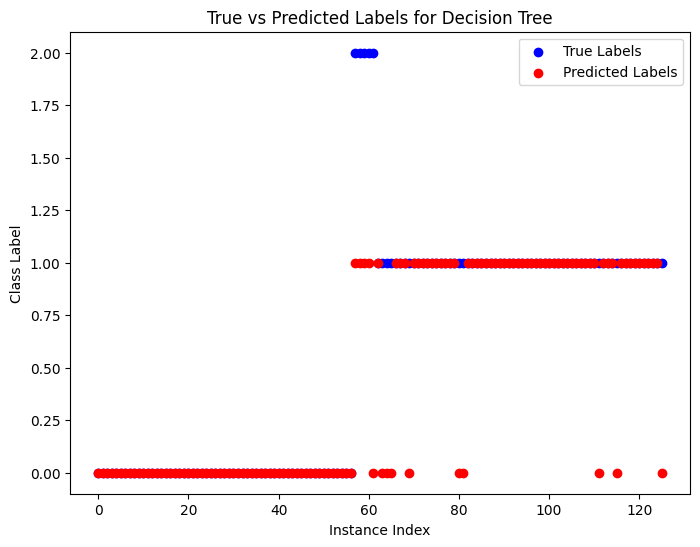

In [92]:
import matplotlib.pyplot as plt

# Plotting the true labels against the predicted labels
plt.figure(figsize=(8, 6))
plt.scatter(range(len(y_test_1)), y_test_1, color='blue', label='True Labels')
plt.scatter(range(len(y_pred_dt)), y_pred_dt, color='red', label='Predicted Labels',)
plt.xlabel('Instance Index')
plt.ylabel('Class Label')
plt.title('True vs Predicted Labels for Decision Tree')
plt.legend()
plt.show()

In [88]:
# Random Forest
y_pred_rf = loaded_random_forest_model.predict(X_test_1)
print(y_pred_rf)


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 1 0 0 0 1 1 1 0 1 1 1 1
 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 0 1 1 1 0 1 1 1 1 0 1 1 1 1 0]


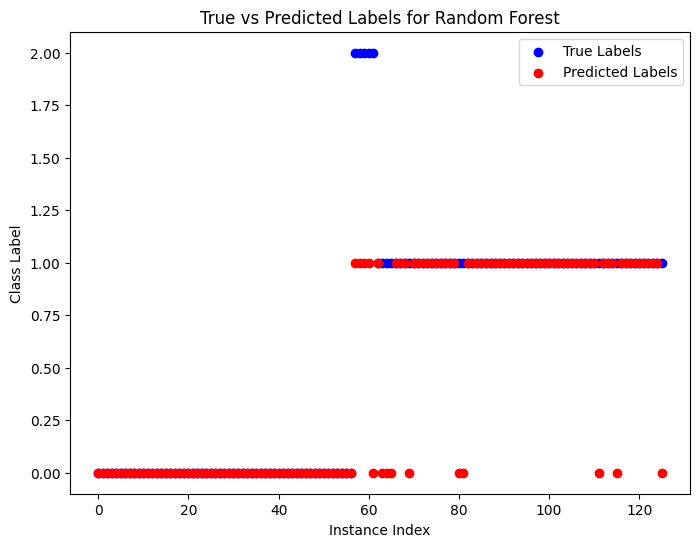

In [89]:
import matplotlib.pyplot as plt

# Plotting the true labels against the predicted labels
plt.figure(figsize=(8, 6))
plt.scatter(range(len(y_test_1)), y_test_1, color='blue', label='True Labels')
plt.scatter(range(len(y_pred_rf)), y_pred_dt, color='red', label='Predicted Labels',)
plt.xlabel('Instance Index')
plt.ylabel('Class Label')
plt.title('True vs Predicted Labels for Random Forest')
plt.legend()
plt.show()

In [90]:
# KNN
y_pred_knn = loaded_knn_model.predict(X_test_2)
print(y_pred_knn)


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


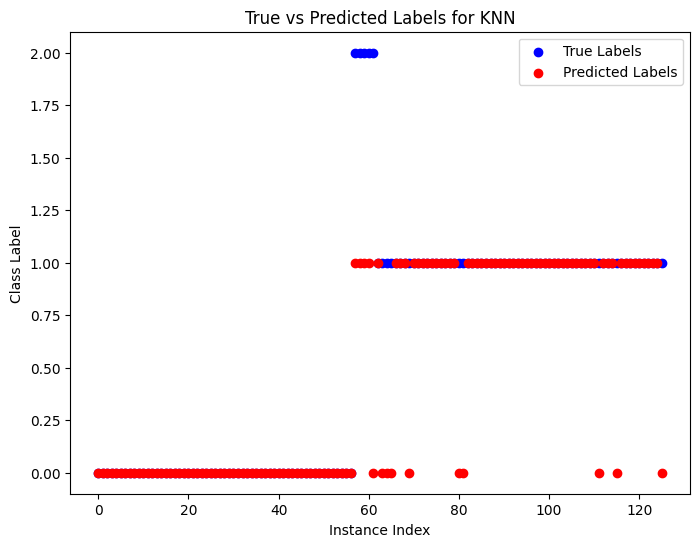

In [91]:
import matplotlib.pyplot as plt

# Plotting the true labels against the predicted labels
plt.figure(figsize=(8, 6))
plt.scatter(range(len(y_test_2)), y_test_1, color='blue', label='True Labels')
plt.scatter(range(len(y_pred_knn)), y_pred_dt, color='red', label='Predicted Labels',)
plt.xlabel('Instance Index')
plt.ylabel('Class Label')
plt.title('True vs Predicted Labels for KNN')
plt.legend()
plt.show()

Evaluation

Confusion matrix

Decision Tree

In [98]:
print(classification_report(y_test_1,y_pred_dt))

              precision    recall  f1-score   support

           0       0.84      0.89      0.86        57
           1       0.85      0.80      0.82        64
           2       0.20      0.20      0.20         5

    accuracy                           0.82       126
   macro avg       0.63      0.63      0.63       126
weighted avg       0.82      0.82      0.82       126



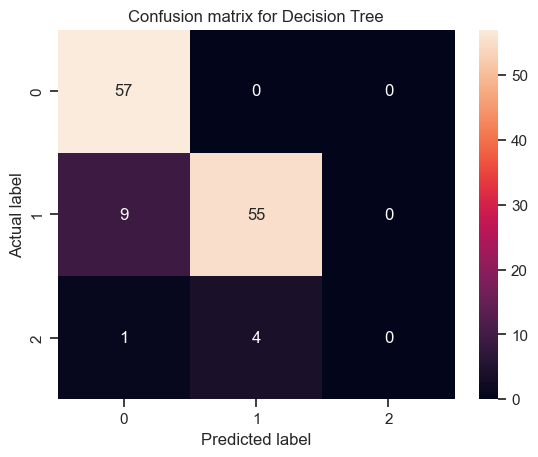

In [444]:
cm_dt = confusion_matrix(y_test_1, y_pred_dt)
sns.heatmap(cm_dt, annot=True)
plt.title('Confusion matrix for Decision Tree')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

Random Forest

In [99]:
print(classification_report(y_test_1,y_pred_rf))

              precision    recall  f1-score   support

           0       0.85      0.96      0.90        57
           1       0.89      0.78      0.83        64
           2       0.00      0.00      0.00         5

    accuracy                           0.83       126
   macro avg       0.58      0.58      0.58       126
weighted avg       0.84      0.83      0.83       126



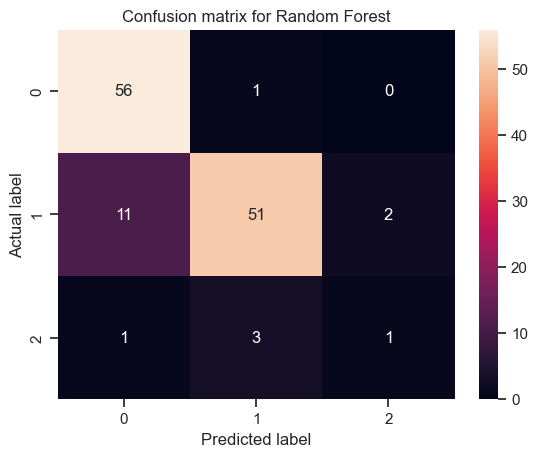

In [445]:
cm_rf = confusion_matrix(y_test_1, y_pred_rf)
sns.heatmap(cm_rf, annot=True)
plt.title('Confusion matrix for Random Forest')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

KNN

In [104]:
print(classification_report(y_test_2,knn_pred))

              precision    recall  f1-score   support

           0       0.91      0.91      0.91        57
           1       0.86      0.92      0.89        64
           2       0.00      0.00      0.00         5

    accuracy                           0.88       126
   macro avg       0.59      0.61      0.60       126
weighted avg       0.85      0.88      0.86       126



c:\Users\Meriem\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Meriem\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Meriem\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

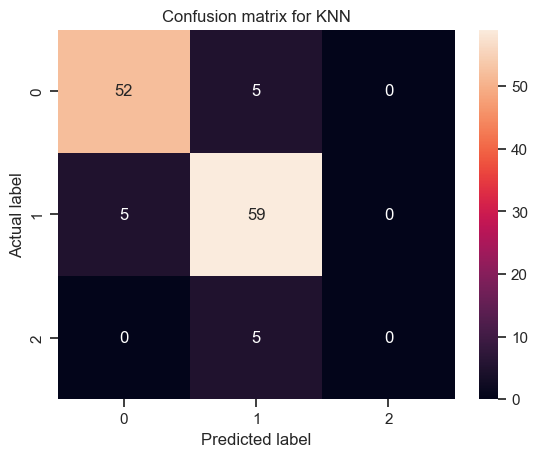

In [446]:
cm_knn = confusion_matrix(y_test_1, knn_pred)
sns.heatmap(cm_knn, annot=True)
plt.title('Confusion matrix for KNN')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

Effet des hyperparametres sur le classifieur:

In [10]:
#Decision Tree
from sklearn.model_selection import GridSearchCV
param_grid={'min_samples_split':[10,20,30,40,50],'max_depth':[50,100,150,200,250,300],'n_feats':[2,4,6,8,10,12]}
Decision_tree_model=DecisionTree()
gs = GridSearchCV(Decision_tree_model,param_grid,scoring='accuracy',cv=5)
gs.fit(X_train_1, y_train_1)

c:\Users\Meriem\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
66 fits failed out of a total of 900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Meriem\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "d:\TRETEC\M2 SII\Data Mining\TP\Projet\algorithms.py", line 30, in fit
    self.root = self._grow_tree(X, y)
                ^^^^^^^^^^^^^^^^^^^^^
  File "d:\TRETEC\M2 SII\Data Mining\TP\Projet\algorithms.py", line 50, in _grow_tree
    lef

GridSearchCV(cv=5,
             estimator=<algorithms.DecisionTree object at 0x000002CDEF5FA660>,
             param_grid={'max_depth': [50, 100, 150, 200, 250, 300],
                         'min_samples_split': [10, 20, 30, 40, 50],
                         'n_feats': [2, 4, 6, 8, 10, 12]},
             scoring='accuracy')

In [22]:
len(gs.cv_results_['params'])

180

In [33]:
for i in range(8):
    r=random.randint(0,len(gs.cv_results_['params']))
    print(gs.cv_results_['params'][r], 'test acc.:', gs.cv_results_['mean_test_score'][r])

{'max_depth': 300, 'min_samples_split': 30, 'n_feats': 10} test acc.: 0.8324040404040403
{'max_depth': 150, 'min_samples_split': 20, 'n_feats': 6} test acc.: 0.7961818181818182
{'max_depth': 100, 'min_samples_split': 50, 'n_feats': 4} test acc.: 0.6930707070707071
{'max_depth': 200, 'min_samples_split': 50, 'n_feats': 10} test acc.: 0.8345050505050505
{'max_depth': 50, 'min_samples_split': 40, 'n_feats': 12} test acc.: 0.8244040404040405
{'max_depth': 50, 'min_samples_split': 10, 'n_feats': 10} test acc.: 0.7901616161616162
{'max_depth': 50, 'min_samples_split': 10, 'n_feats': 8} test acc.: 0.8122828282828282
{'max_depth': 150, 'min_samples_split': 10, 'n_feats': 6} test acc.: 0.7741818181818182


In [21]:
#Random Forest
from sklearn.model_selection import GridSearchCV
param_grid={'n_trees':[10,50,100],'min_samples_split':[10,35,50],'max_depth':[50,150,350],'n_feats':[4,8,12]}
Random_forest_model=RandomForest()
gs_rf = GridSearchCV(Random_forest_model,param_grid,scoring='accuracy',cv=2)
gs_rf.fit(X_train_1, y_train_1)

GridSearchCV(cv=2,
             estimator=<algorithms.RandomForest object at 0x0000025D2BA36090>,
             param_grid={'max_depth': [50, 150, 350],
                         'min_samples_split': [10, 35, 50],
                         'n_feats': [4, 8, 12], 'n_trees': [10, 50, 100]},
             scoring='accuracy')

In [28]:
import random
for i in range(8):
    r=random.randint(0,len(gs_rf.cv_results_['params'])-1)
    print(gs_rf.cv_results_['params'][r], 'test acc.:', gs_rf.cv_results_['mean_test_score'][r])

{'max_depth': 350, 'min_samples_split': 50, 'n_feats': 8, 'n_trees': 50} test acc.: 0.008064516129032258
{'max_depth': 150, 'min_samples_split': 50, 'n_feats': 4, 'n_trees': 100} test acc.: 0.008064516129032258
{'max_depth': 50, 'min_samples_split': 10, 'n_feats': 8, 'n_trees': 10} test acc.: 0.05846774193548387
{'max_depth': 350, 'min_samples_split': 35, 'n_feats': 12, 'n_trees': 10} test acc.: 0.008064516129032258
{'max_depth': 350, 'min_samples_split': 35, 'n_feats': 8, 'n_trees': 50} test acc.: 0.008064516129032258
{'max_depth': 50, 'min_samples_split': 50, 'n_feats': 12, 'n_trees': 50} test acc.: 0.008064516129032258
{'max_depth': 50, 'min_samples_split': 10, 'n_feats': 12, 'n_trees': 10} test acc.: 0.12298387096774194
{'max_depth': 50, 'min_samples_split': 50, 'n_feats': 8, 'n_trees': 10} test acc.: 0.008064516129032258


In [32]:
# KNN
accuracy_knn=[]
for i in range(2,100):
    knn = KNN(k=i)
    knn.fit(X_train_2, y_train_2)
    y_pred = knn.predict(X_test_2)
    accuracy_knn.append((i,accuracy(y_test_2,y_pred)))

In [34]:
for i in range(8):
    r=random.randint(0,len(accuracy_knn))
    print(accuracy_knn[r][0], 'test acc.:', accuracy_knn[r][1])

2 test acc.: 0.7936507936507936
82 test acc.: 0.8650793650793651
37 test acc.: 0.8571428571428571
95 test acc.: 0.8492063492063492
36 test acc.: 0.8650793650793651
75 test acc.: 0.8650793650793651
46 test acc.: 0.8650793650793651
48 test acc.: 0.8650793650793651


(2, 0.7936507936507936)

Mesures de performances

Pour chaque classe:

In [453]:
from tabulate import tabulate

classes = np.unique(y_test_1)
table_data = []

for classe in classes:
    class_accuracy = accuracy(y_test_1, y_pred_dt, classe)
    class_specificity = specificity(y_test_1, y_pred_dt, classe)
    class_precision = precision(y_test_1, y_pred_dt, classe)
    class_recall = recall(y_test_1, y_pred_dt, classe)
    class_f_score = f_score(y_test_1, y_pred_dt, classe)

    table_data.append([f"Class {classe}", class_accuracy, class_specificity, class_precision, class_recall, class_f_score])

headers = ["Class", "Accuracy", "Specificity", "Precision", "Recall", "F-Score"]
table = tabulate(table_data, headers, tablefmt="grid")

print(table)


+---------+------------+---------------+-------------+----------+-----------+
| Class   |   Accuracy |   Specificity |   Precision |   Recall |   F-Score |
+=========+============+===============+=============+==========+===========+
| Class 0 |    1.07018 |      0.855072 |    0.850746 | 1        |  0.919355 |
+---------+------------+---------------+-------------+----------+-----------+
| Class 1 |    0.875   |      0.935484 |    0.932203 | 0.859375 |  0.894309 |
+---------+------------+---------------+-------------+----------+-----------+
| Class 2 |    1.8     |      1        |    0        | 0        |  0        |
+---------+------------+---------------+-------------+----------+-----------+


Globale:

In [454]:
def f_score(y_true,y_pred,c=None):
    matrix=confusion_matrix(y_true,y_pred)
    classes=np.unique(y_true)
    if c==None:
        global_fscore=0
        for i in classes:
            p=precision(y_true,y_pred,i)
            r=recall(y_true,y_pred,i)
            if(p==0 or r==0):
                fscore=0
            else:
                fscore=2/((1/p)+(1/r))
            global_fscore+=(fscore)
        return global_fscore/len(classes)

    else:
        p=precision(y_true,y_pred,c)
        r=recall(y_true,y_pred,c)
        if (p==0 or r==0):
            return 0

        return 2/((1/p)+(1/r))

In [455]:
table_data_global = []

In [456]:
class_accuracy = accuracy(y_test_1, y_pred_dt)
class_specificity = specificity(y_test_1, y_pred_dt)
class_precision = precision(y_test_1, y_pred_dt)
class_recall = recall(y_test_1, y_pred_dt)
class_f_score = f_score(y_test_1, y_pred_dt)
table_data_global.append([f"Methode DT", class_accuracy, class_specificity, class_precision, class_recall, class_f_score])


Random Forest

In [20]:
print(accuracy(y_test_1, y_pred_rf))

0.9047619047619048


In [457]:
from tabulate import tabulate

classes = np.unique(y_test_1)
table_data = []

for classe in classes:
    class_accuracy = accuracy(y_test_1, y_pred_rf, classe)
    class_specificity = specificity(y_test_1, y_pred_rf, classe)
    class_precision = precision(y_test_1, y_pred_rf, classe)
    class_recall = recall(y_test_1, y_pred_rf, classe)
    class_f_score = f_score(y_test_1, y_pred_rf, classe)

    table_data.append([f"Class {classe}", class_accuracy, class_specificity, class_precision, class_recall, class_f_score])

headers = ["Class", "Accuracy", "Specificity", "Precision", "Recall", "F-Score"]
table = tabulate(table_data, headers, tablefmt="grid")

print(table)


+---------+------------+---------------+-------------+----------+-----------+
| Class   |   Accuracy |   Specificity |   Precision |   Recall |   F-Score |
+=========+============+===============+=============+==========+===========+
| Class 0 |    1.07018 |      0.826087 |    0.823529 | 0.982456 |  0.896    |
+---------+------------+---------------+-------------+----------+-----------+
| Class 1 |    0.8125  |      0.935484 |    0.927273 | 0.796875 |  0.857143 |
+---------+------------+---------------+-------------+----------+-----------+
| Class 2 |    2.6     |      0.983471 |    0.333333 | 0.2      |  0.25     |
+---------+------------+---------------+-------------+----------+-----------+


In [458]:
class_accuracy = accuracy(y_test_1, y_pred_rf)
class_specificity = specificity(y_test_1, y_pred_rf)
class_precision = precision(y_test_1, y_pred_rf)
class_recall = recall(y_test_1, y_pred_rf)
class_f_score = f_score(y_test_1, y_pred_rf)
table_data_global.append([f"Methode RF", class_accuracy, class_specificity, class_precision, class_recall, class_f_score])


KNN

In [459]:
from tabulate import tabulate

classes = np.unique(y_test_2)
table_data = []

for classe in classes:
    class_accuracy = accuracy(y_test_2, knn_pred, classe)
    class_specificity = specificity(y_test_2, knn_pred, classe)
    class_precision = precision(y_test_2, knn_pred, classe)
    class_recall = recall(y_test_2, knn_pred, classe)
    class_f_score = f_score(y_test_2, knn_pred, classe)

    table_data.append([f"Class {classe}", class_accuracy, class_specificity, class_precision, class_recall, class_f_score])

headers = ["Class", "Accuracy", "Specificity", "Precision", "Recall", "F-Score"]
table = tabulate(table_data, headers, tablefmt="grid")

print(table)


+---------+------------+---------------+-------------+----------+-----------+
| Class   |   Accuracy |   Specificity |   Precision |   Recall |   F-Score |
+=========+============+===============+=============+==========+===========+
| Class 0 |   1        |      0.927536 |    0.912281 | 0.912281 |  0.912281 |
+---------+------------+---------------+-------------+----------+-----------+
| Class 1 |   0.921875 |      0.83871  |    0.855072 | 0.921875 |  0.887218 |
+---------+------------+---------------+-------------+----------+-----------+
| Class 2 |   2        |      1        |    0        | 0        |  0        |
+---------+------------+---------------+-------------+----------+-----------+


In [460]:
class_accuracy = accuracy(y_test_2, knn_pred)
class_specificity = specificity(y_test_2, knn_pred)
class_precision = precision(y_test_2, knn_pred)
class_recall = recall(y_test_2, knn_pred)
class_f_score = f_score(y_test_2, knn_pred)
table_data_global.append([f"Methode KNN", class_accuracy, class_specificity, class_precision, class_recall, class_f_score])


In [461]:
headers = ["Class", "Accuracy", "Specificity", "Precision", "Recall", "F-Score"]
table = tabulate(table_data_global, headers, tablefmt="grid")

print(table)

+-------------+------------+---------------+-------------+----------+-----------+
| Class       |   Accuracy |   Specificity |   Precision |   Recall |   F-Score |
+=============+============+===============+=============+==========+===========+
| Methode DT  |   0.888889 |      0.930185 |    0.594317 | 0.619792 |  0.604555 |
+-------------+------------+---------------+-------------+----------+-----------+
| Methode RF  |   0.857143 |      0.915014 |    0.694712 | 0.659777 |  0.667714 |
+-------------+------------+---------------+-------------+----------+-----------+
| Methode KNN |   0.880952 |      0.922082 |    0.589118 | 0.611385 |  0.599833 |
+-------------+------------+---------------+-------------+----------+-----------+


Temps d'execution

Decision Tree

Temps d'execution par rapport aux hyperparametres:

In [35]:
# For min_sample_split
time_execution=[]
for i in range(10,100):
    start_time = time.time()
    Decision_tree_model = DecisionTree(min_samples_split=i, max_depth=50) # Keep the best max_depth
    Decision_tree_model.fit(X_train_1, y_train_1)
    y_pred_dt = Decision_tree_model.predict(X_test_1)
    end_time = time.time()
    execute_time = end_time - start_time
    time_execution.append((i,(execute_time)))


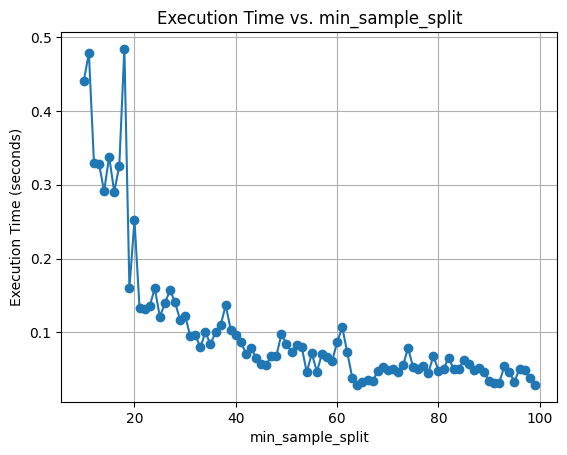

In [36]:
# Extract values for plotting
min_sample_splits, execution_times = zip(*time_execution)

# Plot the results
plt.plot(min_sample_splits, execution_times)
plt.title('Execution Time vs. min_sample_split')
plt.xlabel('min_sample_split')
plt.ylabel('Execution Time (seconds)')
plt.grid(True)
plt.show()

In [37]:
# For max_depth
time_execution=[]
for i in range(50,500,50):
    start_time = time.time()
    Decision_tree_model = DecisionTree(min_samples_split=30,max_depth=i) # Keep the best value for min_samples_split
    Decision_tree_model.fit(X_train_1, y_train_1)
    y_pred_dt =Decision_tree_model.predict(X_test_1)
    end_time = time.time()
    execute_time = end_time - start_time
    time_execution.append((i,(execute_time)))


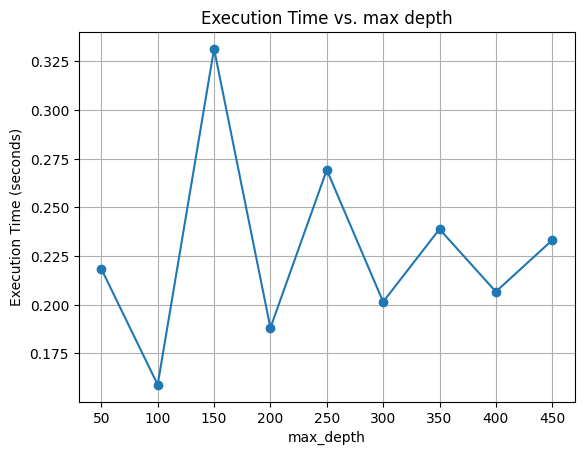

In [38]:
# Extract values for plotting
max_depth, execution_times = zip(*time_execution)

# Plot the results
plt.plot(max_depth, execution_times, marker='o')
plt.title('Execution Time vs. max depth')
plt.xlabel('max_depth')
plt.ylabel('Execution Time (seconds)')
plt.grid(True)
plt.show()

In [41]:
# For n_features
time_execution=[]
for i in range(2,12):
    start_time = time.time()
    Decision_tree_model = DecisionTree(min_samples_split=30,max_depth=50,n_feats=i) # Keep the best values for min_samples_split and max_depth
    Decision_tree_model.fit(X_train_1, y_train_1)
    y_pred_dt = Decision_tree_model.predict(X_test_1)
    end_time = time.time()
    execute_time = end_time - start_time
    time_execution.append((i,(execute_time)))


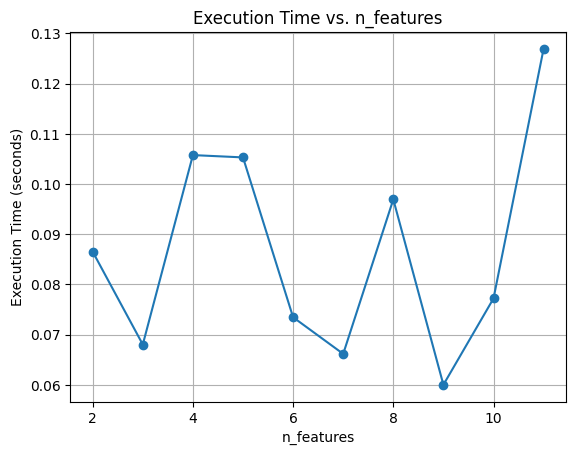

In [42]:
# Extract values for plotting
n_features, execution_times = zip(*time_execution)

# Plot the results
plt.plot(n_features, execution_times, marker='o')
plt.title('Execution Time vs. n_features')
plt.xlabel('n_features')
plt.ylabel('Execution Time (seconds)')
plt.grid(True)
plt.show()

Temps d'execution par rapport au training et test:

In [45]:
# Using the best model we calculate the mean time to fit and predict
time_fit=0
time_predict=0
for i in range(100):
    start_time = time.time()
    loaded_decision_tree_model.fit(X_train_1, y_train_1)
    end_time = time.time()
    time_fit+=(end_time-start_time)
    start_time = time.time()
    y_pred_dt=loaded_decision_tree_model.predict(X_test_1)
    end_time = time.time()
    time_predict+=(end_time-start_time)
time_fit=time_fit/100
time_predict=time_predict/100

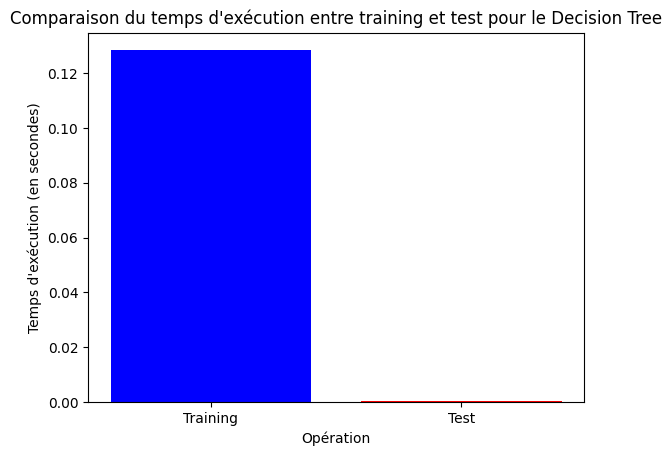

In [46]:
import matplotlib.pyplot as plt

# Noms des algorithmes
operation = ['Training', 'Test']

# Création d'un diagramme à barres
plt.bar(operation,[time_fit,time_predict], color=['blue','red'])

# Ajout de titres et d'étiquettes
plt.title('Comparaison du temps d\'exécution entre training et test pour le Decision Tree')
plt.xlabel('Opération')
plt.ylabel('Temps d\'exécution (en secondes)')

# Affichage du diagramme
plt.show()


Random Forest

Temps d'execution par rapport aux hyperparmetres:

In [48]:
# For n_trees
time_execution=[]
for i in range(10,100,10):
    start_time = time.time()
    Random_forest_model = RandomForest(n_trees=i,min_samples_split=35, max_depth=350) # Keep the best min_samples_split max_depth
    Random_forest_model.fit(X_train_1, y_train_1)
    y_pred_rf = Random_forest_model.predict(X_test_1)
    end_time = time.time()
    execute_time = end_time - start_time
    time_execution.append((i,(execute_time)))


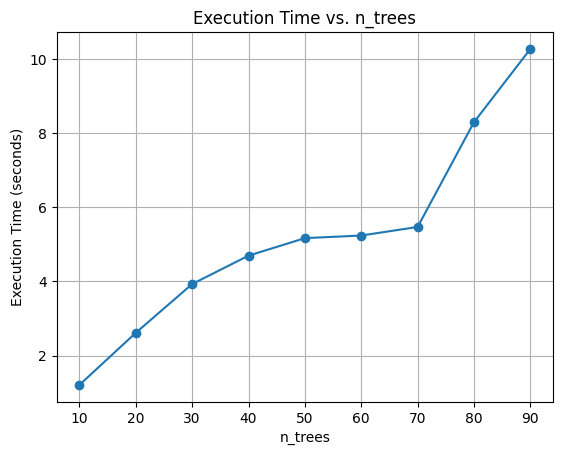

In [49]:
# Extract values for plotting
n_trees, execution_times = zip(*time_execution)

# Plot the results
plt.plot(n_trees, execution_times, marker='o')
plt.title('Execution Time vs. n_trees')
plt.xlabel('n_trees')
plt.ylabel('Execution Time (seconds)')
plt.grid(True)
plt.show()

In [53]:
# For min_sample_split
time_execution=[]
for i in range(15,100):
    start_time = time.time()
    Random_forest_model = RandomForest(min_samples_split=i,n_trees=10, max_depth=350) # Keep the best max_depth and n_trees
    Random_forest_model.fit(X_train_1, y_train_1)
    y_pred_rf = Random_forest_model.predict(X_test_1)
    end_time = time.time()
    execute_time = end_time - start_time
    time_execution.append((i,(execute_time)))


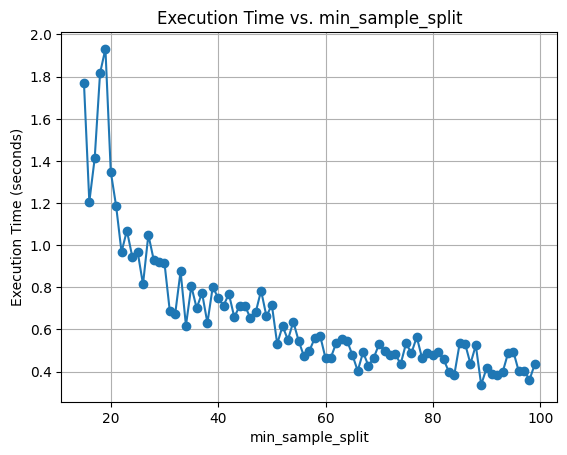

In [54]:
# Extract values for plotting
min_sample_split, execution_times = zip(*time_execution)

# Plot the results
plt.plot(min_sample_split, execution_times)
plt.title('Execution Time vs. min_sample_split')
plt.xlabel('min_sample_split')
plt.ylabel('Execution Time (seconds)')
plt.grid(True)
plt.show()

In [55]:
# For max_depth
time_execution=[]
for i in range(50,500,50):
    start_time = time.time()
    Random_forest_model = RandomForest(min_samples_split=35,n_trees=10, max_depth=i) # Keep the best min_sample_split and n_trees
    Random_forest_model.fit(X_train_1, y_train_1)
    y_pred_rf = Random_forest_model.predict(X_test_1)
    end_time = time.time()
    execute_time = end_time - start_time
    time_execution.append((i,(execute_time)))


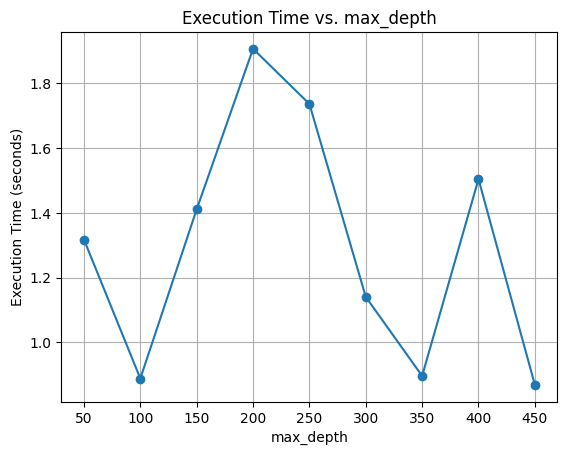

In [56]:
# Extract values for plotting
max_depth, execution_times = zip(*time_execution)

# Plot the results
plt.plot(max_depth, execution_times, marker='o')
plt.title('Execution Time vs. max_depth')
plt.xlabel('max_depth')
plt.ylabel('Execution Time (seconds)')
plt.grid(True)
plt.show()

In [58]:
# For n_features
time_execution=[]
for i in range(2,12):
    start_time = time.time()
    Random_forest_model = RandomForest(min_samples_split=35,n_trees=10, max_depth=350, n_features=i) # Keep the best min_sample_split, max_depth and n_trees
    Random_forest_model.fit(X_train_1, y_train_1)
    y_pred_rf = Random_forest_model.predict(X_test_1)
    end_time = time.time()
    execute_time = end_time - start_time
    time_execution.append((i,(execute_time)))


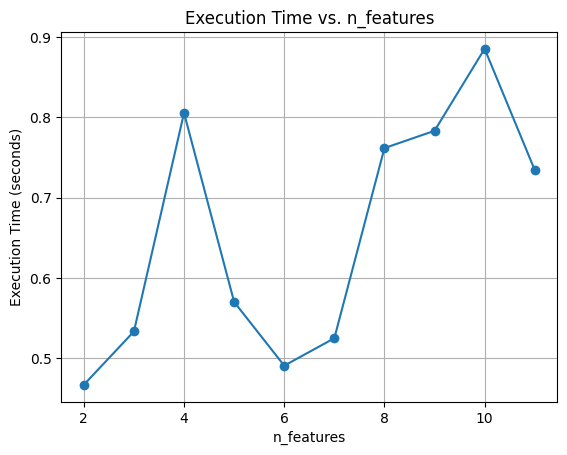

In [59]:
# Extract values for plotting
n_features, execution_times = zip(*time_execution)

# Plot the results
plt.plot(n_features, execution_times, marker='o')
plt.title('Execution Time vs. n_features')
plt.xlabel('n_features')
plt.ylabel('Execution Time (seconds)')
plt.grid(True)
plt.show()

Temps d'execution par rapport au training et test: 

In [60]:
# Using the best model we calculate the mean time to fit and predict
time_fit=0
time_predict=0
for i in range(100):
    start_time = time.time()
    loaded_random_forest_model.fit(X_train_1, y_train_1)
    end_time = time.time()
    time_fit+=(end_time-start_time)
    start_time = time.time()
    y_pred_rf=loaded_random_forest_model.predict(X_test_1)
    end_time = time.time()
    time_predict+=(end_time-start_time)
time_fit=time_fit/100
time_predict=time_predict/100

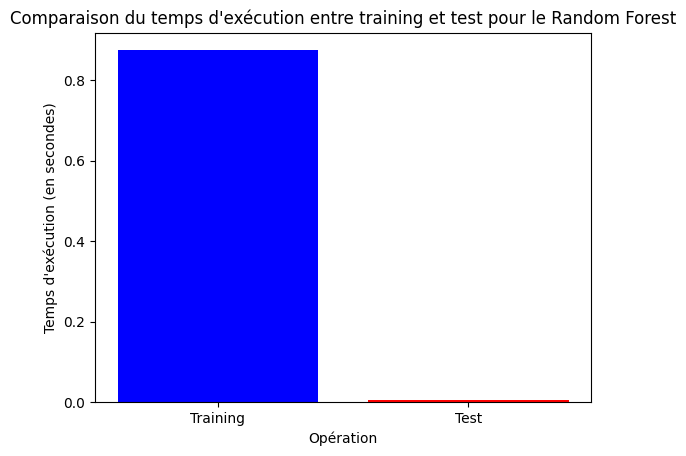

In [61]:
import matplotlib.pyplot as plt

# Noms des algorithmes
operation = ['Training', 'Test']

# Création d'un diagramme à barres
plt.bar(operation,[time_fit,time_predict], color=['blue','red'])

# Ajout de titres et d'étiquettes
plt.title('Comparaison du temps d\'exécution entre training et test pour le Random Forest')
plt.xlabel('Opération')
plt.ylabel('Temps d\'exécution (en secondes)')

# Affichage du diagramme
plt.show()


KNN

Temps d'execution par rapport aux hyperparametres:

In [62]:
# For K number of nearest neighbours
time_execution=[]
for i in range(2,100):
    start_time = time.time()
    knn_model = KNN(k=i) 
    knn_model.fit(X_train_2, y_train_2)
    y_pred_knn = knn_model.predict(X_test_2)
    end_time = time.time()
    execute_time = end_time - start_time
    time_execution.append((i,(execute_time)))


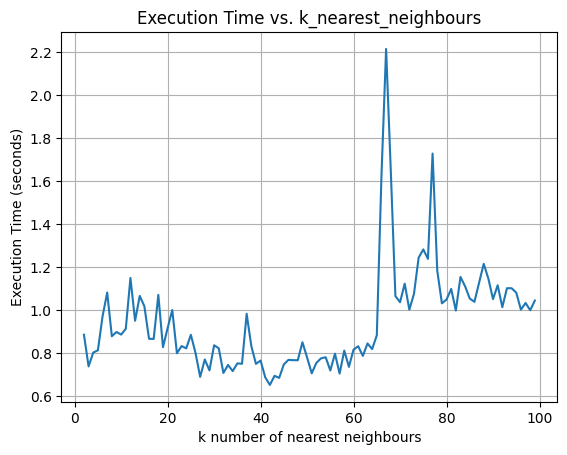

In [64]:
# Extract values for plotting
k, execution_times = zip(*time_execution)

# Plot the results
plt.plot(k, execution_times)
plt.title('Execution Time vs. k_nearest_neighbours')
plt.xlabel('k number of nearest neighbours')
plt.ylabel('Execution Time (seconds)')
plt.grid(True)
plt.show()

Comparaison temps d'execution entre les algorithmes

In [65]:
# Calculate mean time execution for every classifier
temps_execution=[]
time_dt=0
time_rf=0
time_knn=0
for i in range(100):
    start_time = time.time()
    loaded_decision_tree_model.fit(X_train_1, y_train_1)
    y_pred_dt = loaded_decision_tree_model.predict(X_test_1)
    end_time = time.time()
    time_dt+=(end_time-start_time)
    start_time = time.time()
    loaded_random_forest_model.fit(X_train_1, y_train_1)
    y_pred_rf = loaded_random_forest_model.predict(X_test_1)
    end_time = time.time()
    time_rf+=(end_time-start_time)
    start_time = time.time()
    knn_model.fit(X_train_2, y_train_2)
    y_pred_knn = knn_model.predict(X_test_2)
    end_time = time.time()
    time_knn+=(end_time-start_time)
time_dt=time_dt/100
time_rf=time_rf/100
time_knn=time_knn/100
time_execution=[time_dt,time_rf,time_knn]


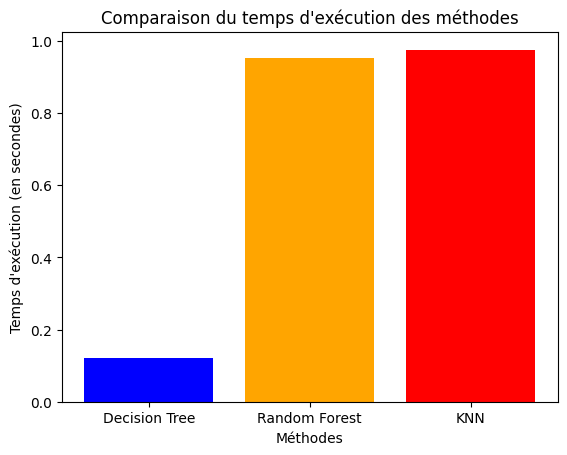

In [67]:
import matplotlib.pyplot as plt

# Noms des algorithmes
algorithmes = ['Decision Tree', 'Random Forest', 'KNN']

# Création d'un diagramme à barres
plt.bar(algorithmes, time_execution, color=['blue', 'orange', 'red'])

# Ajout de titres et d'étiquettes
plt.title('Comparaison du temps d\'exécution des méthodes')
plt.xlabel('Méthodes')
plt.ylabel('Temps d\'exécution (en secondes)')

# Affichage du diagramme
plt.show()
